In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from bokeh.plotting import figure
from bokeh.tile_providers import get_provider, WIKIMEDIA, CARTODBPOSITRON, STAMEN_TERRAIN, STAMEN_TONER, ESRI_IMAGERY, OSM
from bokeh.io import output_notebook, show



[nltk_data] Downloading package stopwords to /Users/kate/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kate/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kate/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Getting Data

Make sure that all files are in your working directory before running the code below

In [ ]:
# create separate dataframes from data
df_atlanta=pd.read_json('atlanta.json')
df_austin=pd.read_json('austin.json')
df_chicago=pd.read_json('chicago.json')
df_houston=pd.read_json('houston.json')
df_la=pd.read_json('la.json')
df_ny=pd.read_json('ny.json')
df_oc=pd.read_json('oc.json')
df_sandiego=pd.read_json('sandiego.json')
df_seattle=pd.read_json('seattle.json')
df_sf=pd.read_json('sf.json')


# function to update locations to main city name, all axcept 'United States'
def update_location(dataframe, updated_location):
    dataframe['location'] = np.where(~dataframe['location'].str.contains("United States", na=False), updated_location, dataframe['location'])

#update locations
update_location(df_atlanta, 'atlanta, ga')
update_location(df_austin, 'austin, tx')
update_location(df_chicago, 'chicago, il')
update_location(df_houston, 'houston, tx')
update_location(df_la, 'los angeles, ca')
update_location(df_ny, 'new york, ny')
update_location(df_oc, 'orange county, ca')
update_location(df_sandiego, 'san diego, ca')
update_location(df_seattle, 'seattle, wa')
update_location(df_sf, 'san francisco, ca')

#combine all to one dataframe
df=pd.concat([df_atlanta,df_austin,df_chicago, df_houston, df_la, df_ny, df_oc, df_sandiego, df_seattle, df_sf],axis=0) 

df.shape

(6123, 9)

Cleaning

In [ ]:

# drop unnecessary columns
df = df.drop(columns=['reviews', 'id', 'postedAt', 'scrapedAt', 'url'])

# make lowercase
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

# delete duplicate rows
df = df.drop_duplicates()

# create senior jobs
senior = df[((df['positionName'].str.contains('senior'))
             | (df['positionName'].str.contains('sr.')))]

# all remote jobs (positionName has either 'remote' or 'virtual')
remote = df[(df['positionName'].str.contains('remote')) | (
    df['positionName'].str.contains('virtual')) | (df['location'].str.contains('united states'))]

# check for any NaN values
df.isnull().values.any()


False

In [ ]:
# drop senior rows
df_nonsenior = (pd.merge(df,senior, indicator=True, how='outer')
         .query('_merge=="left_only"')
         .drop('_merge', axis=1))

df_nonsenior.shape

(3896, 4)

DATA EXPLORATION

In [ ]:
# remote vs in person

remote_chart = remote.groupby('location').count()
remote_chart = remote_chart.drop(columns=['company', 'description'])
remote_chart = remote_chart.rename(columns={'positionName':'count_remote'})
remote_chart.reset_index()

df_chart = df.groupby('location').count()
df_chart = df_chart.drop(columns=['company', 'description'])
df_chart = df_chart.rename(columns={'positionName':'count_all'})
df_chart.reset_index()

df_remote_and_all= df_chart.merge(remote_chart, how='inner', on='location')

df_remote_and_all = df_remote_and_all.drop(index='united states')

df_remote_and_all

,count_all,count_remote
location,,
"atlanta, ga",702,36
"austin, tx",357,22
"chicago, il",756,34
"houston, tx",378,16
"los angeles, ca",578,19
"new york, ny",830,33
"orange county, ca",328,10
"san diego, ca",230,6
"san francisco, ca",475,10


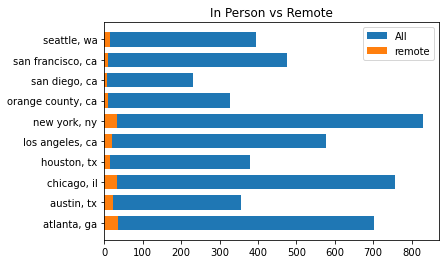

In [ ]:
labels = df_remote_and_all.index

width = 0.7   

fig, ax = plt.subplots()


ax.barh(labels, df_remote_and_all['count_all'], width, label='All')
ax.barh(labels, df_remote_and_all['count_remote'], width, label='remote')


ax.set_title('In Person vs Remote')
ax.legend()


plt.show()

In [ ]:
# Visual representation of locations 

df_map = df_nonsenior.groupby('location').count()
df_map = df_map.drop(columns=['company', 'description'])
df_map = df_map.rename(columns={'positionName':'count'})

df_map = df_map.sort_values(by='count',ascending=False)

df_map['Latitude'] = [40.7128, 41.8781, 33.7490, 34.0522, 37.7749, 29.7604, 47.6062, 30.2672, 33.7175, 32.7157, 37.0902]
df_map['Longitude'] = [-74.0060, -87.6298, -84.3880, -118.2437, -122.4194, -95.3698, -122.3321, -97.7431, -117.8311, -117.1611, -95.7129]


from pyproj import Proj, transform
inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')


lons, lats = [], []
for lon, lat in list(zip(df_map["Longitude"], df_map["Latitude"])):
    x, y = transform(outProj,inProj,lon,lat)
    lons.append(x)
    lats.append(y)
    

df_map["MercatorX"] = lons
df_map["MercatorY"] = lats   

wikimedia = get_provider(WIKIMEDIA)
cartodb = get_provider(CARTODBPOSITRON)

us_lon1, us_lat1 = transform(outProj,inProj,-140,10)
us_lon2, us_lat2 = transform(outProj,inProj,-50,55)

p = figure(plot_width=800, plot_height=600,
           x_range=(us_lon1, us_lon2), y_range=(us_lat1, us_lat2),
           x_axis_type="mercator", y_axis_type="mercator",
           tooltips=[
                    ("location", "@location"), ("count", "@count"), ("(Long, Lat)", "(@Longitude, @Latitude)")
                    ],
           title="Data Analyst Job Postings")

p.add_tile(cartodb)

p.circle(x="MercatorX", y="MercatorY",
         size=20,
         fill_color="tomato", line_color="tomato",
         fill_alpha=0.3,
         source=df_map,
         )

show(p)



/Users/kate/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/kate/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-19-1091d6b7a1c6>:20: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = transform(

Text(0.5, 1.0, 'Jobs per City')

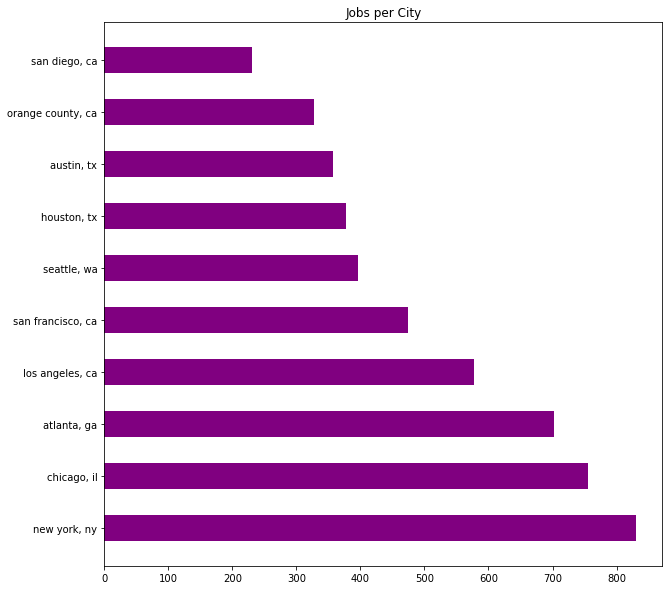

In [ ]:
# bar chart of number of jobs per city

df_map_chart = df_remote_and_all.drop(columns = 'count_remote')
df_map_chart = df_map_chart.sort_values(by='count_all',ascending=False)

plt.figure(figsize=(10,10))
plt.barh(df_map_chart.index,df_map_chart['count_all'], height = 0.5, color='purple')

plt.title("Jobs per City")

In [ ]:
# Create list of skills (each skill group is divieded into 1 or 2 word list)

list1_1 = [('sql',) , ('mysql',) , ('python',), ('oracle',), ('sybase',), ('tableau',), ('nosql',), ('weka',), ('r',), ('hadoop',), ('sas',), ('spss',), ('matlab',)]
list1_2 = [('microsoft', 'excel'), ('google', 'analytics'), ('power', 'bi')]
list2_1 = [('mathematics',), ('etl',), ('statistical',), ('database',),('vlookup',),('querying',),('testing',),('reporting',),('dashboards',)]
list2_2 = [('data', 'modeling'), ('data', 'collection'), ('data', 'cleaning'), ('data', 'visualization'), ('pattern', 'recognition'), ('machine', 'learning'), ('data', 'processing'), ('data', 'mining'), ('business', 'analysis'), ('business', 'strategy'), ('big', 'data'), ('predictive', 'analysis'), ('data', 'extraction'),('data','warehousing')]
list3_1 = [('communication,'), ('collaboration,'), ('presentation,'),('troubleshoot')]
list3_2 = [('critical', 'thinking'), ('public', 'speaking'), ('attention', 'detail'), ('problem', 'solving'), ('project', 'management'), ('team', 'work'), ('decision', 'making'), ('logical', 'thinking')]

N - GRAMS

In [ ]:
# n - grams set up / preprocess

def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = unicodedata.normalize('NFKD', text).lower()
  words = re.sub(r'[^\w\s]', '', text).split()

  return [wnl.lemmatize(word) for word in words if word not in stopwords]


words = basic_clean(''.join(str(df_nonsenior['description'].tolist())))




Uni Grams

In [ ]:
# 1 grams - does NOT provide sufficient information 

uni_grams = pd.Series(nltk.ngrams(words, 1)).value_counts()[:1000000000].to_frame()

uni_grams = uni_grams.rename(columns={0: 'counts'})



uni_grams.head(10)

#uni_grams.to_excel("uni_grams.xlsx",
             #sheet_name='uni_grams') 



,counts
"(data,)",28528
"(business,)",18365
"(team,)",10713
"(experience,)",10647
"(work,)",10541
"(management,)",7234
"(analysis,)",6958
"(process,)",6834
"(project,)",6735
"(skill,)",6372


In [ ]:
# find SPECIFIC uni grams from the list1_1

df_list1_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list1_1:
        df_list1_1 = df_list1_1.append(uni_grams.loc[[x], :])
        
df_list1_1 = df_list1_1.reset_index()          

df_list1_1.head(100)

,index,counts
0,"(sql,)",2325
1,"(tableau,)",1170
2,"(python,)",817
3,"(r,)",537
4,"(oracle,)",445
5,"(spss,)",137
6,"(mysql,)",59
7,"(hadoop,)",48
8,"(nosql,)",30
9,"(matlab,)",21


In [ ]:
# find SPECIFIC uni grams from the list2_1

df_list2_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list2_1:
        df_list2_1 = df_list2_1.append(uni_grams.loc[[x], :])
        
df_list2_1 = df_list2_1.reset_index()        

df_list2_1.head(100)

,index,counts
0,"(reporting,)",3972
1,"(database,)",2041
2,"(testing,)",1551
3,"(statistical,)",1244
4,"(mathematics,)",490
5,"(etl,)",349
6,"(querying,)",130
7,"(vlookup,)",41


In [ ]:
# find SPECIFIC uni grams from the list3_1

df_list3_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list3_1:
        df_list3_1 = df_list3_1.append(uni_grams.loc[[x], :])
        
df_list3_1 = df_list3_1.reset_index()        

df_list3_1.head(100)

,index


BI GRAMS

In [ ]:
# 2 grams

two_grams = pd.Series(nltk.ngrams(words, 2)).value_counts()[:10000000].to_frame()
two_grams.reset_index()

two_grams = two_grams.rename(columns={0: 'counts'})
 

two_grams.head(20)

#two_grams.to_excel("two_grams.xlsx",
             #sheet_name='two_grams')  

# provides good amount of information


,counts
"(year, experience)",2211
"(data, analyst)",1709
"(business, analyst)",1673
"(equal, opportunity)",1543
"(sexual, orientation)",1469
"(national, origin)",1427
"(data, analysis)",1420
"(gender, identity)",1244
"(opportunity, employer)",1204
"(data, analytics)",1105


In [ ]:
# find SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          

df_list1_2.head(100)

,index,counts
0,"(power, bi)",521
1,"(microsoft, excel)",245
2,"(google, analytics)",126


In [ ]:
# find SPECIFIC bi grams from the list2_2

df_list2_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list2_2:
        df_list2_2 = df_list2_2.append(two_grams.loc[[x], :])
        
df_list2_2 = df_list2_2.reset_index()          

df_list2_2.head(100)

,index,counts
0,"(data, visualization)",837
1,"(business, analysis)",491
2,"(data, collection)",394
3,"(machine, learning)",273
4,"(data, mining)",247
5,"(data, modeling)",244
6,"(data, warehousing)",174
7,"(big, data)",154
8,"(business, strategy)",136
9,"(data, processing)",81


In [ ]:
# find SPECIFIC bi grams from the list3_2

df_list3_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list3_2:
        df_list3_2 = df_list3_2.append(two_grams.loc[[x], :])
        
df_list3_2 = df_list3_2.reset_index()          

df_list3_2.head(100)

,index,counts
0,"(project, management)",861
1,"(attention, detail)",503
2,"(problem, solving)",469
3,"(critical, thinking)",275
4,"(decision, making)",243
5,"(team, work)",153
6,"(public, speaking)",10
7,"(logical, thinking)",4


TRI GRAMS

In [ ]:
# 3 grams - NOT USING, BUT CAN STILL MENTION: does NOT provide more information than 2 grams
three_grams = pd.Series(nltk.ngrams(words, 3)).value_counts()[:10000000].to_frame()
three_grams.head(20)

#three_grams.to_excel("three_grams.xlsx",
             #sheet_name='three_grams')  


,0
"(equal, opportunity, employer)",1087
"(sexual, orientation, gender)",844
"(without, regard, race)",764
"(race, color, religion)",753
"(orientation, gender, identity)",743
"(regard, race, color)",644
"(employment, without, regard)",555
"(equal, employment, opportunity)",499
"(receive, consideration, employment)",474
"(color, religion, sex)",471


In [ ]:
# create 3 data frame with different skill types

df_tool = pd.DataFrame()
df_hard = pd.DataFrame()
df_soft = pd.DataFrame()

#TOOL SKILLS
df_tool = df_tool.append(df_list1_1)
df_tool = df_tool.append(df_list1_2)
df_tool = df_tool.sort_values(by='counts',ascending=False)

tool_list = ['sql', 'tableau', 'python', 'r', 'power bi', 'oracle', 'microsoft excel','spss', 'google analytics', 'mysql','hadoop', 'nosql', 'matlab','sybase', 'weka']
df_tool = df_tool.rename(columns={'index':'skill'})
df_tool['skill'] = tool_list

#HARD SKILLS
df_hard = df_hard.append(df_list2_1)
df_hard = df_hard.append(df_list2_2)
df_hard = df_hard.sort_values(by='counts',ascending=False)

hard_list = ['reporting','database','testing','statistical','data visualization', 'business analysis', 'mathematics', 'data collection', 'etl', 'machine learning' , 'data mining', 'data modeling', 'data warehousing', 'big data', 'business strategy','querying', 'data processing', 'data extraction', 'data cleaning', 'vlookup','predictive analysis', 'pattern recognition']
df_hard = df_hard.rename(columns={'index':'skill'})
df_hard['skill'] = hard_list

#SOFT SKILLS
df_soft = df_soft.append(df_list3_1)
df_soft = df_soft.append(df_list3_2)
df_soft = df_soft.sort_values(by='counts',ascending=False)

soft_list = ['project management', 'attention to detail', 'problem solving', 'critical thinking', 'decision making', 'team work', 'public speaking', 'logical thinking']
df_soft = df_soft.rename(columns={'index':'skill'})
df_soft['skill'] = soft_list

df_soft.head(20)

,skill,counts
0,project management,861.0
1,attention to detail,503.0
2,problem solving,469.0
3,critical thinking,275.0
4,decision making,243.0
5,team work,153.0
6,public speaking,10.0
7,logical thinking,4.0


# TOOL SKILLS visualization

In [1]:
# word cloud
d_tool = dict(zip(df_tool.skill, df_tool.counts))


wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_tool)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

NameError: ignored

In [ ]:
# bar chart

plt.figure(figsize=(10,10))
plt.barh(df_tool['skill'],df_tool['counts'], height = 0.5, color='purple')

plt.title("Tool Skills")


HARD SKILLS visualization

In [ ]:
# word cloud
d_hard = dict(zip(df_hard.skill, df_hard.counts))


wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_hard)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# bar chart

plt.figure(figsize=(10,10))
plt.barh(df_hard['skill'],df_hard['counts'], height = 0.5, color='purple')

plt.title("Hard Skills")


SOFT SKILLS visualization

In [ ]:
# word cloud
d_soft = dict(zip(df_soft.skill, df_soft.counts))


wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d_soft)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# bar chart

plt.figure(figsize=(10,10))
plt.barh(df_soft['skill'],df_soft['counts'], height = 0.5, color='purple')

plt.title("Soft Skills")


Combining all n grams together

In [ ]:
#create df with all skills

df_skills = pd.DataFrame()

df_skills = df_skills.append(df_tool)
df_skills = df_skills.append(df_hard)
df_skills = df_skills.append(df_soft)

df_skills = df_skills.sort_values(by='counts',ascending=False)


df_skills.head(100)

visualization of ALL SKILLS

In [ ]:

# word cloud


d = dict(zip(df_skills.skill, df_skills.counts))


import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# bar chart
plt.figure(figsize=(10,10))
plt.barh(df_skills['skill'],df_skills['counts'], height = 0.5, color='purple')

plt.title("All Skills")


# Departent specific skills

## Financial

In [ ]:
# Create list of skills (each skill group is divieded into 1 or 2 word list)

list1_1 = [('sql',) , ('mysql',) , ('python',), ('oracle',), ('sybase',), ('tableau',), ('nosql',), ('weka',), ('r',), ('hadoop',), ('sas',), ('spss',), ('matlab',)]
list1_2 = [('microsoft', 'excel'), ('google', 'analytics'), ('power', 'bi')]
list2_1 = [('mathematics',), ('etl',), ('statistical',), ('database',),('vlookup',),('querying',),('testing',),('reporting',),('dashboards',)]
list2_2 = [('data', 'modeling'), ('data', 'collection'), ('data', 'cleaning'), ('data', 'visualization'), ('pattern', 'recognition'), ('machine', 'learning'), ('data', 'processing'), ('data', 'mining'), ('business', 'analysis'), ('business', 'strategy'), ('big', 'data'), ('predictive', 'analysis'), ('data', 'extraction'),('data','warehousing')]
list3_1 = [('communication,'), ('collaboration,'), ('presentation,'),('troubleshoot')]
list3_2 = [('critical', 'thinking'), ('public', 'speaking'), ('attention', 'detail'), ('problem', 'solving'), ('project', 'management'), ('team', 'work'), ('decision', 'making'), ('logical', 'thinking')]

In [ ]:
# Finance-Accounting
Finance = df[((df['positionName'].str.contains('finance')) | (df['positionName'].str.contains('financial'))| (df['positionName'].str.contains('account'))| (df['positionName'].str.contains('cost')))]
Finance.head()

,positionName,company,location,description
0,accounting specialist - data compliance analyst,ist management services,"atlanta, ga",overview:\n\nwe are seeking a candidate to joi...
110,financial computation and data modeling analyst,state of georgia,"atlanta, ga",position: financial computation and data model...
137,staff accountant and data analyst,gusto holdings llc,"atlanta, ga",financial reporting/accounting\ncreate journal...
150,financial risk data analyst i,federal home loan,"atlanta, ga",our vision for diversity and inclusion\nfhlban...
210,financial operations analyst,purchasing power,"atlanta, ga",work at purchasing powerpurchasing power is lo...


In [ ]:
# n - grams set up / preprocess

def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = unicodedata.normalize('NFKD', text).lower()
  words = re.sub(r'[^\w\s]', '', text).split()

  return [wnl.lemmatize(word) for word in words if word not in stopwords]


words = basic_clean(''.join(str(Finance['description'].tolist())))

In [ ]:
# 1 grams - does NOT provide sufficient information 

uni_grams = pd.Series(nltk.ngrams(words, 1)).value_counts()[:1000000000].to_frame()

uni_grams = uni_grams.rename(columns={0: 'counts'})



uni_grams.head(10)

#uni_grams.to_excel("uni_grams.xlsx",
             #sheet_name='uni_grams') 



,counts
"(data,)",1065
"(financial,)",940
"(business,)",617
"(analysis,)",495
"(experience,)",438
"(work,)",435
"(management,)",396
"(team,)",395
"(finance,)",349
"(accounting,)",345


In [ ]:
# find SPECIFIC uni grams from the list1_1

df_list1_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list1_1:
        df_list1_1 = df_list1_1.append(uni_grams.loc[[x], :])
        
df_list1_1 = df_list1_1.reset_index()          
df_list1_1.head(100)

,index,counts
0,"(sql,)",70
1,"(oracle,)",67
2,"(tableau,)",51
3,"(python,)",19
4,"(r,)",17
5,"(mysql,)",3
6,"(matlab,)",2
7,"(hadoop,)",1
8,"(nosql,)",1


In [ ]:

# find SPECIFIC uni grams from the list2_1

df_list2_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list2_1:
        df_list2_1 = df_list2_1.append(uni_grams.loc[[x], :])
        
df_list2_1 = df_list2_1.reset_index()        
df_list2_1.head(100)



,index,counts
0,"(reporting,)",265
1,"(statistical,)",68
2,"(database,)",66
3,"(testing,)",34
4,"(mathematics,)",22
5,"(etl,)",8
6,"(querying,)",5
7,"(vlookup,)",2


In [ ]:
# find SPECIFIC uni grams from the list3_1

df_list3_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list3_1:
        df_list3_1 = df_list3_1.append(uni_grams.loc[[x], :])
        
df_list3_1 = df_list3_1.reset_index()        
df_list3_1.head(100)

,index


In [ ]:
# 2 grams

two_grams = pd.Series(nltk.ngrams(words, 2)).value_counts()[:10000000].to_frame()
two_grams.reset_index()

two_grams = two_grams.rename(columns={0: 'counts'})
 

two_grams.head(20)

#two_grams.to_excel("two_grams.xlsx",
             #sheet_name='two_grams')  

# provides good amount of information


,counts
"(financial, analyst)",86
"(year, experience)",84
"(data, analysis)",73
"(sexual, orientation)",63
"(national, origin)",58
"(analyze, data)",56
"(financial, data)",55
"(financial, analysis)",54
"(equal, opportunity)",52
"(ad, hoc)",50


In [ ]:
# find SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          

df_list1_2.head(100)

,index,counts
0,"(power, bi)",23
1,"(microsoft, excel)",18
2,"(google, analytics)",3


In [ ]:
# find SPECIFIC bi grams from the list2_2

df_list2_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list2_2:
        df_list2_2 = df_list2_2.append(two_grams.loc[[x], :])
        
df_list2_2 = df_list2_2.reset_index()          

df_list2_2.head(100)

,index,counts
0,"(data, visualization)",25
1,"(business, analysis)",8
2,"(data, mining)",7
3,"(big, data)",6
4,"(data, collection)",6
5,"(machine, learning)",6
6,"(data, modeling)",5
7,"(data, extraction)",3
8,"(business, strategy)",2
9,"(data, processing)",2


In [ ]:
# find SPECIFIC bi grams from the list3_2

df_list3_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list3_2:
        df_list3_2 = df_list3_2.append(two_grams.loc[[x], :])
        
df_list3_2 = df_list3_2.reset_index()          

df_list3_2.head(100)

,index,counts
0,"(problem, solving)",30
1,"(project, management)",29
2,"(attention, detail)",23
3,"(decision, making)",16
4,"(critical, thinking)",10
5,"(team, work)",9
6,"(logical, thinking)",1


In [ ]:
# create 3 data frame with different skill types

df_tool = pd.DataFrame()
df_hard = pd.DataFrame()
df_soft = pd.DataFrame()

#TOOL SKILLS
df_tool = df_tool.append(df_list1_1)
df_tool = df_tool.append(df_list1_2)
df_tool = df_tool.sort_values(by='counts',ascending=False)
#df_tool.head(20)


#HARD SKILLS
df_hard = df_hard.append(df_list2_1)
df_hard = df_hard.append(df_list2_2)
df_hard = df_hard.sort_values(by='counts',ascending=False)
#df_hard.head(20)


#SOFT SKILLS
df_soft = df_soft.append(df_list3_1)
df_soft = df_soft.append(df_list3_2)
df_soft = df_soft.sort_values(by='counts',ascending=False)
df_soft.head(20)


,index,counts
0,"(problem, solving)",30.0
1,"(project, management)",29.0
2,"(attention, detail)",23.0
3,"(decision, making)",16.0
4,"(critical, thinking)",10.0
5,"(team, work)",9.0
6,"(logical, thinking)",1.0


# Marketing

In [ ]:
# Marketing
Marketing = df[(df['positionName'].str.contains('market'))]
Marketing.head()

,positionName,company,location,description
212,marketing data and rebate analyst,weg electric corp,"atlanta, ga",about weg electric corp.weg is the largest ind...
232,business analyst with capital markets,kutir technologies,"atlanta, ga",business analysis (technology management) – 3 ...
234,data & marketing analyst- strategic communicat...,kennesaw state university,"atlanta, ga","job summary\n\nmeasures, reports, and enhances..."
238,marketing data analyst,bitcoin depot,"atlanta, ga",marketing data analyst\n\nbitcoin depot (bitco...
318,marketing business analyst,bekaert nv,"atlanta, ga",bekaert is a world market and technology leade...


In [ ]:
# n - grams set up / preprocess

def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = unicodedata.normalize('NFKD', text).lower()
  words = re.sub(r'[^\w\s]', '', text).split()

  return [wnl.lemmatize(word) for word in words if word not in stopwords]


words = basic_clean(''.join(str(Marketing['description'].tolist())))

In [ ]:
# 1 grams - does NOT provide sufficient information 

uni_grams = pd.Series(nltk.ngrams(words, 1)).value_counts()[:1000000000].to_frame()

uni_grams = uni_grams.rename(columns={0: 'counts'})



uni_grams.head(10)

#uni_grams.to_excel("uni_grams.xlsx",
             #sheet_name='uni_grams') 

    
    

,counts
"(data,)",1110
"(marketing,)",637
"(business,)",528
"(team,)",410
"(experience,)",353
"(work,)",326
"(market,)",303
"(analytics,)",301
"(analysis,)",237
"(opportunity,)",233


In [ ]:
# find SPECIFIC uni grams from the list1_1

df_list1_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list1_1:
        df_list1_1 = df_list1_1.append(uni_grams.loc[[x], :])
        
df_list1_1 = df_list1_1.reset_index()          
df_list1_1.head(100)

,index,counts
0,"(sql,)",74
1,"(tableau,)",50
2,"(python,)",30
3,"(r,)",22
4,"(spss,)",4
5,"(mysql,)",4
6,"(oracle,)",2
7,"(matlab,)",1
8,"(hadoop,)",1


In [ ]:
# find SPECIFIC uni grams from the list2_1

df_list2_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list2_1:
        df_list2_1 = df_list2_1.append(uni_grams.loc[[x], :])
        
df_list2_1 = df_list2_1.reset_index()        
df_list2_1.head(100)

,index,counts
0,"(reporting,)",140
1,"(database,)",53
2,"(statistical,)",48
3,"(testing,)",43
4,"(mathematics,)",24
5,"(etl,)",9
6,"(querying,)",6
7,"(vlookup,)",2


In [ ]:
# find SPECIFIC uni grams from the list3_1

df_list3_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list3_1:
        df_list3_1 = df_list3_1.append(uni_grams.loc[[x], :])
        
df_list3_1 = df_list3_1.reset_index()        
df_list3_1.head(100)

,index


In [ ]:
# 2 grams

two_grams = pd.Series(nltk.ngrams(words, 2)).value_counts()[:10000000].to_frame()
two_grams.reset_index()

two_grams = two_grams.rename(columns={0: 'counts'})
 

two_grams.head(20)

#two_grams.to_excel("two_grams.xlsx",
             #sheet_name='two_grams')  

# provides good amount of information



,counts
"(data, analyst)",82
"(marketing, data)",64
"(year, experience)",64
"(market, data)",60
"(data, analytics)",59
"(equal, opportunity)",57
"(sexual, orientation)",56
"(opportunity, employer)",53
"(national, origin)",49
"(marketing, team)",48


In [ ]:
# find SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          

df_list1_2.head(100)

,index,counts
0,"(google, analytics)",33
1,"(power, bi)",22
2,"(microsoft, excel)",11


In [ ]:
# find SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          

df_list1_2.head(100)

,index,counts
0,"(google, analytics)",33
1,"(power, bi)",22
2,"(microsoft, excel)",11


In [ ]:
# find SPECIFIC bi grams from the list2_2

df_list2_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list2_2:
        df_list2_2 = df_list2_2.append(two_grams.loc[[x], :])
        
df_list2_2 = df_list2_2.reset_index()          

df_list2_2.head(100)

,index,counts
0,"(data, visualization)",48
1,"(data, mining)",16
2,"(business, analysis)",13
3,"(data, modeling)",13
4,"(big, data)",9
5,"(data, collection)",9
6,"(machine, learning)",8
7,"(data, extraction)",4
8,"(data, warehousing)",4
9,"(data, processing)",4


In [ ]:
# find SPECIFIC bi grams from the list3_2

df_list3_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list3_2:
        df_list3_2 = df_list3_2.append(two_grams.loc[[x], :])
        
df_list3_2 = df_list3_2.reset_index()          

df_list3_2.head(100)

,index,counts
0,"(attention, detail)",18
1,"(problem, solving)",17
2,"(project, management)",15
3,"(team, work)",8
4,"(critical, thinking)",8
5,"(decision, making)",8


In [ ]:
# create 3 data frame with different skill types

df_tool = pd.DataFrame()
df_hard = pd.DataFrame()
df_soft = pd.DataFrame()

#TOOL SKILLS
df_tool = df_tool.append(df_list1_1)
df_tool = df_tool.append(df_list1_2)
df_tool = df_tool.sort_values(by='counts',ascending=False)
#df_tool.head(20)


#HARD SKILLS
df_hard = df_hard.append(df_list2_1)
df_hard = df_hard.append(df_list2_2)
df_hard = df_hard.sort_values(by='counts',ascending=False)
#df_hard.head(20)


#SOFT SKILLS
df_soft = df_soft.append(df_list3_1)
df_soft = df_soft.append(df_list3_2)
df_soft = df_soft.sort_values(by='counts',ascending=False)
df_soft.head(20)



,index,counts
0,"(attention, detail)",18.0
1,"(problem, solving)",17.0
2,"(project, management)",15.0
3,"(team, work)",8.0
4,"(critical, thinking)",8.0
5,"(decision, making)",8.0


## Operation

In [ ]:
# Operations


Operations = df[(df['positionName'].str.contains('operation'))| (df['positionName'].str.contains('logistic'))| (df['positionName'].str.contains('chain'))]
Operations.head()

,positionName,company,location,description
2,"supply chain data analyst (100% remote, must w...",the mom project,"atlanta, ga",our global manufacturing client is a seeking s...
57,supply chain data analyst,children's healthcare of atlanta,"atlanta, ga",work schedule/days: day / monday - friday\nemp...
66,"analyst, human resources operational services",delta,"atlanta, ga","united states, georgia, atlanta\nhr & labor\n0..."
112,operations data analyst,costar group,"atlanta, ga",operations data analyst\n<br>\njob description...
138,data operations analyst - secureworks sales - ...,secureworks,"atlanta, ga",secureworks® (nasdaq: scwx) a global cybersecu...


In [ ]:
# n - grams set up / preprocess

def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = unicodedata.normalize('NFKD', text).lower()
  words = re.sub(r'[^\w\s]', '', text).split()

  return [wnl.lemmatize(word) for word in words if word not in stopwords]


words = basic_clean(''.join(str(Operations['description'].tolist())))

In [ ]:
# 1 grams - does NOT provide sufficient information 

uni_grams = pd.Series(nltk.ngrams(words, 1)).value_counts()[:1000000000].to_frame()

uni_grams = uni_grams.rename(columns={0: 'counts'})



uni_grams.head(10)

#uni_grams.to_excel("uni_grams.xlsx",
             #sheet_name='uni_grams') 

    
    

,counts
"(data,)",1536
"(business,)",882
"(team,)",633
"(experience,)",563
"(work,)",545
"(operation,)",526
"(process,)",478
"(management,)",453
"(supply,)",384
"(support,)",375


In [ ]:
# find SPECIFIC uni grams from the list1_1

df_list1_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list1_1:
        df_list1_1 = df_list1_1.append(uni_grams.loc[[x], :])
        
df_list1_1 = df_list1_1.reset_index()          
df_list1_1.head(100)

,index,counts
0,"(sql,)",101
1,"(tableau,)",71
2,"(python,)",28
3,"(r,)",14
4,"(oracle,)",6
5,"(hadoop,)",1
6,"(mysql,)",1
7,"(matlab,)",1


In [ ]:
# find SPECIFIC uni grams from the list2_1

df_list2_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list2_1:
        df_list2_1 = df_list2_1.append(uni_grams.loc[[x], :])
        
df_list2_1 = df_list2_1.reset_index()        
df_list2_1.head(100)

,index,counts
0,"(reporting,)",265
1,"(database,)",86
2,"(testing,)",33
3,"(statistical,)",29
4,"(mathematics,)",20
5,"(etl,)",12
6,"(querying,)",4
7,"(vlookup,)",3


In [ ]:
# find SPECIFIC uni grams from the list3_1

df_list3_1 = pd.DataFrame()

for x in uni_grams.index:
    if x in list3_1:
        df_list3_1 = df_list3_1.append(uni_grams.loc[[x], :])
        
df_list3_1 = df_list3_1.reset_index()        
df_list3_1.head(100)

,index


In [ ]:
# 2 grams

two_grams = pd.Series(nltk.ngrams(words, 2)).value_counts()[:10000000].to_frame()
two_grams.reset_index()

two_grams = two_grams.rename(columns={0: 'counts'})
 

two_grams.head(20)

#two_grams.to_excel("two_grams.xlsx",
             #sheet_name='two_grams')  

# provides good amount of information




,counts
"(supply, chain)",320
"(year, experience)",150
"(sexual, orientation)",102
"(national, origin)",98
"(equal, opportunity)",94
"(gender, identity)",93
"(sale, operation)",84
"(opportunity, employer)",79
"(qualified, applicant)",74
"(race, color)",72


In [ ]:
# find SPECIFIC bi grams from the list1_2

df_list1_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list1_2:
        df_list1_2 = df_list1_2.append(two_grams.loc[[x], :])
        
df_list1_2 = df_list1_2.reset_index()          

df_list1_2.head(100)

,index,counts
0,"(power, bi)",32
1,"(microsoft, excel)",19
2,"(google, analytics)",2


In [ ]:
# find SPECIFIC bi grams from the list2_2

df_list2_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list2_2:
        df_list2_2 = df_list2_2.append(two_grams.loc[[x], :])
        
df_list2_2 = df_list2_2.reset_index()          

df_list2_2.head(100)

,index,counts
0,"(data, visualization)",26
1,"(business, analysis)",18
2,"(data, mining)",17
3,"(data, processing)",12
4,"(data, modeling)",9
5,"(machine, learning)",7
6,"(big, data)",7
7,"(business, strategy)",4
8,"(data, collection)",4
9,"(data, warehousing)",3


In [ ]:
# find SPECIFIC bi grams from the list3_2

df_list3_2 = pd.DataFrame()

for x in two_grams.index:
    if x in list3_2:
        df_list3_2 = df_list3_2.append(two_grams.loc[[x], :])
        
df_list3_2 = df_list3_2.reset_index()          

df_list3_2.head(100)

,index,counts
0,"(project, management)",43
1,"(problem, solving)",31
2,"(attention, detail)",30
3,"(critical, thinking)",16
4,"(team, work)",8
5,"(decision, making)",7
6,"(logical, thinking)",1
7,"(public, speaking)",1


In [ ]:
# create 3 data frame with different skill types

df_tool = pd.DataFrame()
df_hard = pd.DataFrame()
df_soft = pd.DataFrame()

#TOOL SKILLS
#df_tool = df_tool.append(df_list1_1)
#df_tool = df_tool.append(df_list1_2)
#df_tool = df_tool.sort_values(by='counts',ascending=False)
#df_tool.head(20)


#HARD SKILLS
#df_hard = df_hard.append(df_list2_1)
#df_hard = df_hard.append(df_list2_2)
#df_hard = df_hard.sort_values(by='counts',ascending=False)
#df_hard.head(20)


#SOFT SKILLS
df_soft = df_soft.append(df_list3_1)
df_soft = df_soft.append(df_list3_2)
df_soft = df_soft.sort_values(by='counts',ascending=False)
df_soft.head(20)




,index,counts
0,"(project, management)",43.0
1,"(problem, solving)",31.0
2,"(attention, detail)",30.0
3,"(critical, thinking)",16.0
4,"(team, work)",8.0
5,"(decision, making)",7.0
6,"(logical, thinking)",1.0
7,"(public, speaking)",1.0
